This notebook is part of the deepcell-spots documentation: https://deepcell-spots.readthedocs.io/

# Singleplex FISH Analysis

In [1]:
import glob
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from deepcell_toolbox.processing import histogram_normalization,normalize
from deepcell_toolbox.deep_watershed import deep_watershed
from deepcell.applications import CytoplasmSegmentation,NuclearSegmentation
from deepcell_spots.applications import Polaris,SpotDetection
from deepcell_spots.singleplex import *

class OverrideCytoplasmSegmentation(CytoplasmSegmentation):

    def __init__(self, model=None):
        super(CytoplasmSegmentation, self).__init__(model, model_image_shape=(512, 512, 1))
        # Override preprocessing input
        self.preprocessing_fn = histogram_normalization        
        self.postprocessing_fn = deep_watershed

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


### Import images

In [2]:
from tensorflow.keras.utils import get_file
from deepcell.datasets import Dataset

def load_data(self, path=None, test_size=0.2, seed=0):
    path = path if path else self.path
    
    basepath = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))
    prefix = path.split(os.path.sep)[:-1]
    data_dir = os.path.join(basepath, *prefix) if prefix else basepath
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    elif not os.path.isdir(data_dir):
        raise IOError('{} exists but is not a directory'.format(data_dir))

    path = get_file(path,
                    origin=self.url,
                    file_hash=self.file_hash)
    
    data = Image.open(path)
    
    return(data)

Dataset.load_data = load_data

In [3]:
from deepcell.datasets import Dataset

datafile = Dataset(
    path='scGFP_Maximum intensity projection.tif',
    url='https://deepcell-data.s3.us-west-1.amazonaws.com/spot_detection/singleplex/scGFP_Maximum+intensity+projection.tif',
    file_hash='a0e5c38ef3b26e521d3837f1098393c4',
    metadata={})
image_stack = datafile.load_data()

In [4]:
image_stack.seek(0)
fluor_image = np.expand_dims(np.array(image_stack), axis=[0,-1])
image_stack.seek(1)
cyto_image = np.expand_dims(np.array(image_stack), axis=[0,-1])
image_stack.seek(2)
nuc_image = np.expand_dims(np.array(image_stack), axis=[0,-1])
image_stack.seek(3)
spots_image = np.expand_dims(np.array(image_stack), axis=[0,-1])

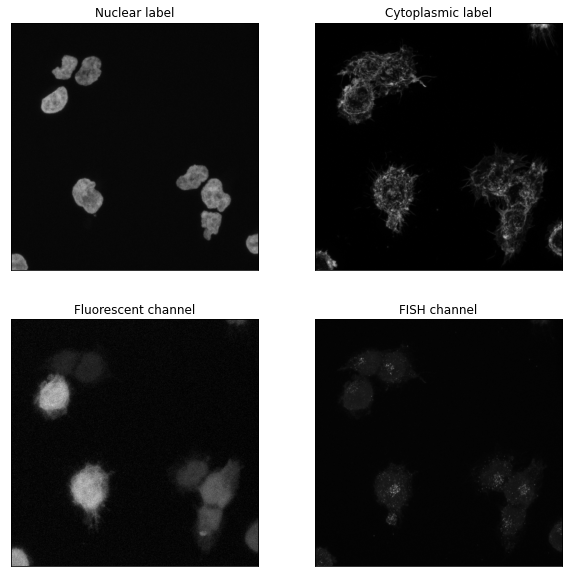

In [5]:
fig,ax = plt.subplots(2,2,figsize=(10,10))

ax[0,0].imshow(nuc_image[0,...,0],cmap='gray')
ax[0,0].set_title('Nuclear label')
ax[0,1].imshow(cyto_image[0,...,0],cmap='gray')
ax[0,1].set_title('Cytoplasmic label')
ax[1,0].imshow(fluor_image[0,...,0],cmap='gray')
ax[1,0].set_title('Fluorescent channel')
ax[1,1].imshow(spots_image[0,...,0],cmap='gray')
ax[1,1].set_title('FISH channel')

for i in range(np.shape(ax)[0]):
    for ii in range(np.shape(ax)[1]):
        ax[i,ii].set_xticks([])
        ax[i,ii].set_yticks([])

plt.show()

### Cytoplasmic segmentation

In [6]:
# Polaris app performs cytoplasmic segmentation by default
app = Polaris()

2022-11-22 21:39:19.676991: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: UNKNOWN ERROR (34)
2022-11-22 21:39:19.677050: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2022-11-22 21:39:19.677350: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# image_mpp is estimate for pixel size in microns
cyto_pred = app.predict(spots_image=spots_image, segmentation_image=fluor_image, image_mpp=0.2)

/usr/local/lib/python3.8/dist-packages/deepcell_toolbox/deep_watershed.py:179: FutureWarning: `selem` is a deprecated argument name for `h_maxima`. It will be removed in version 1.0. Please use `footprint` instead.
  markers = h_maxima(image=maxima,


In [8]:
df_spots = cyto_pred[0]
df_intensities = cyto_pred[1]
segmentation_result = cyto_pred[2]

In [9]:
df_spots

,x,y,batch_id,cell_id,probability,predicted_id,predicted_name
0,869,418,0,8,None,None,None
1,891,424,0,8,None,None,None
2,895,392,0,8,None,None,None
3,871,388,0,8,None,None,None
4,810,922,0,6,None,None,None
...,...,...,...,...,...,...,...
402,356,170,0,4,None,None,None
403,798,981,0,6,None,None,None
404,1040,990,0,9,None,None,None
405,921,390,0,8,None,None,None


In [10]:
df_intensities

,0
0,0.991651
1,0.990847
2,0.990732
3,0.990556
4,0.989664
...,...
402,0.950238
403,0.950187
404,0.950111
405,0.950086


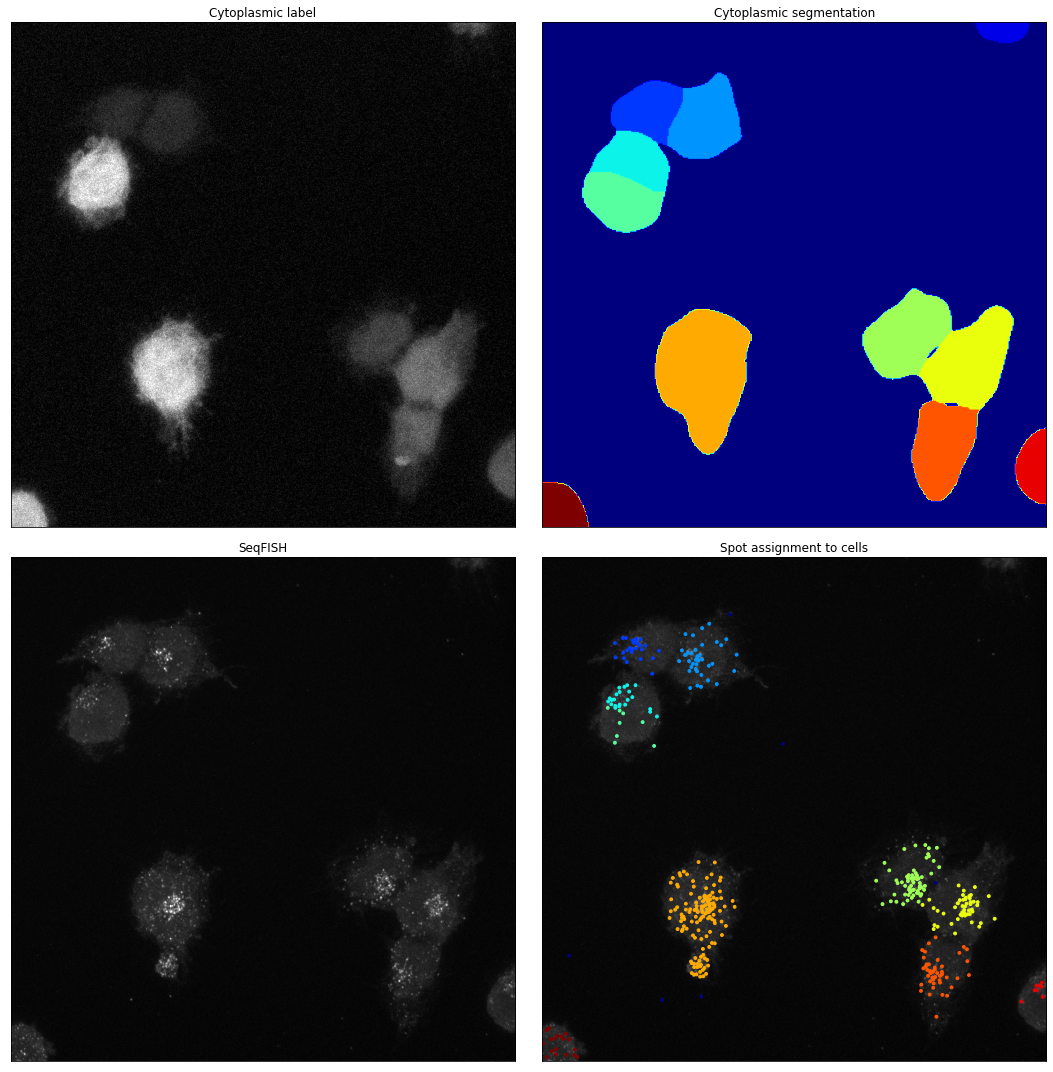

In [11]:
fig,ax = plt.subplots(2,2,figsize=(15,15))

ax[0,0].imshow(fluor_image[0,...,0],cmap='gray',vmax=200)
ax[0,0].set_title('Cytoplasmic label')
ax[0,1].imshow(segmentation_result[0,...,0],cmap='jet')
ax[0,1].set_title('Cytoplasmic segmentation')
ax[1,0].imshow(spots_image[0,...,0],cmap='gray',vmax=100)
ax[1,0].set_title('SeqFISH')
ax[1,1].imshow(spots_image[0,...,0],cmap='gray',vmax=100)
ax[1,1].scatter(df_spots.y, df_spots.x,c=df_spots.cell_id,cmap='jet', s=8)
ax[1,1].set_title('Spot assignment to cells')

for i in range(np.shape(ax)[0]):
    for ii in range(np.shape(ax)[1]):
        ax[i,ii].set_xticks([])
        ax[i,ii].set_yticks([])

plt.tight_layout()
plt.show()

### Nuclear segmentation

In [12]:
# `segmentation_compartment` variable can be set to 'nucleus', 'cytoplasm', or 'None'
app = Polaris(segmentation_type='nucleus')

In [13]:
nuc_pred = app.predict(spots_image=spots_image, segmentation_image=nuc_image, image_mpp=0.15)

/usr/local/lib/python3.8/dist-packages/deepcell_toolbox/deep_watershed.py:179: FutureWarning: `selem` is a deprecated argument name for `h_maxima`. It will be removed in version 1.0. Please use `footprint` instead.
  markers = h_maxima(image=maxima,


In [14]:
df_spots = nuc_pred[0]
df_intensities = nuc_pred[1]
segmentation_result = nuc_pred[2]

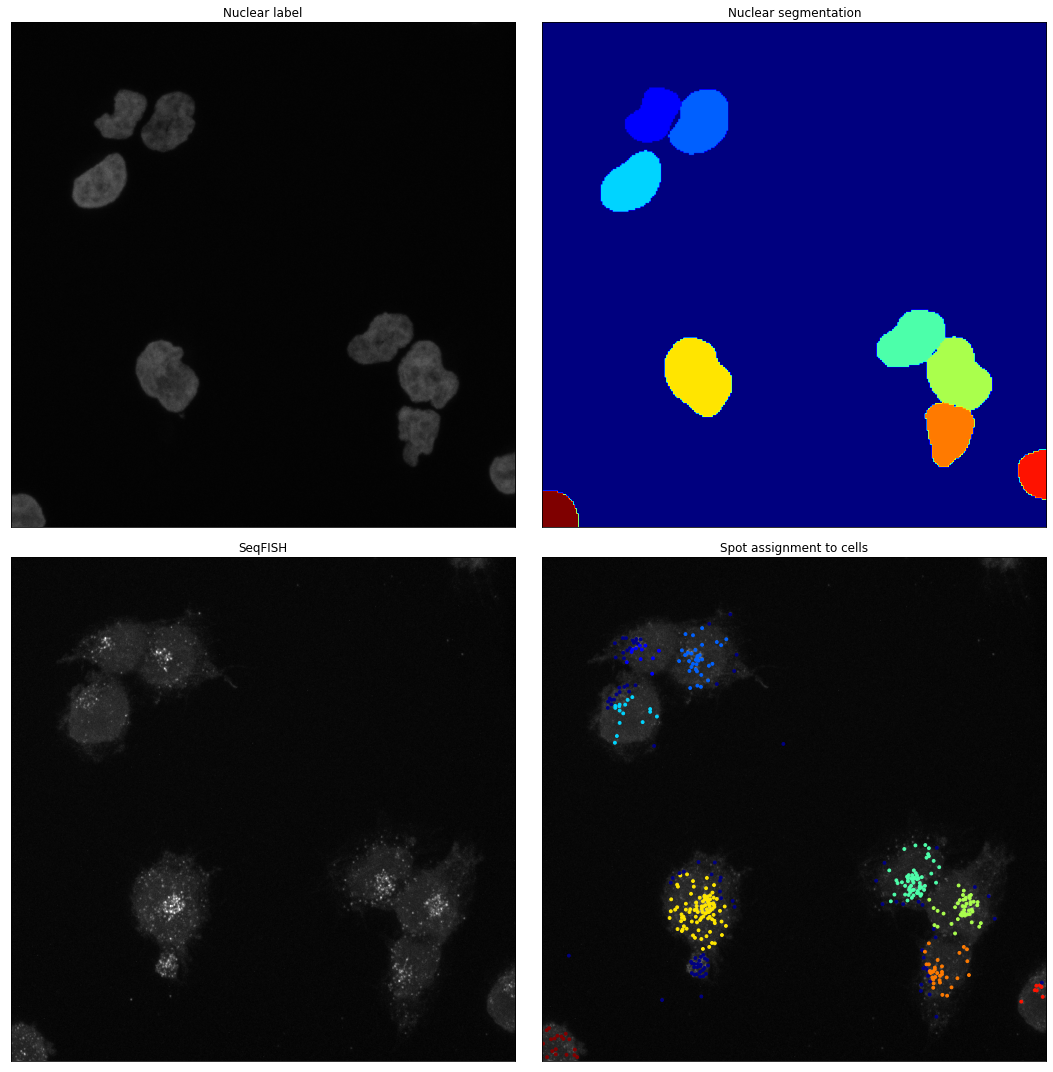

In [15]:
fig,ax = plt.subplots(2,2,figsize=(15,15))

ax[0,0].imshow(nuc_image[0,...,0],cmap='gray',vmax=100)
ax[0,0].set_title('Nuclear label')
ax[0,1].imshow(segmentation_result[0,...,0],cmap='jet')
ax[0,1].set_title('Nuclear segmentation')
ax[1,0].imshow(spots_image[0,...,0],cmap='gray',vmax=100)
ax[1,0].set_title('SeqFISH')
ax[1,1].imshow(spots_image[0,...,0],cmap='gray',vmax=100)
ax[1,1].scatter(df_spots.y, df_spots.x,c=df_spots.cell_id,cmap='jet', s=8)
ax[1,1].set_title('Spot assignment to cells')

for i in range(np.shape(ax)[0]):
    for ii in range(np.shape(ax)[1]):
        ax[i,ii].set_xticks([])
        ax[i,ii].set_yticks([])

plt.tight_layout()
plt.show()

### No segmentation

In [16]:
app = Polaris(segmentation_type='no segmentation')

/usr/local/lib/python3.8/dist-packages/deepcell_spots/applications/polaris.py:180: UserWarning: No segmentation application instantiated.
  warnings.warn('No segmentation application instantiated.')


In [17]:
# if `segmentation_type` is 'no segmentation', app returns a list of lists
spots_pred = app.predict(spots_image=spots_image)

In [18]:
df_spots = spots_pred[0]
df_intensities = spots_pred[1]

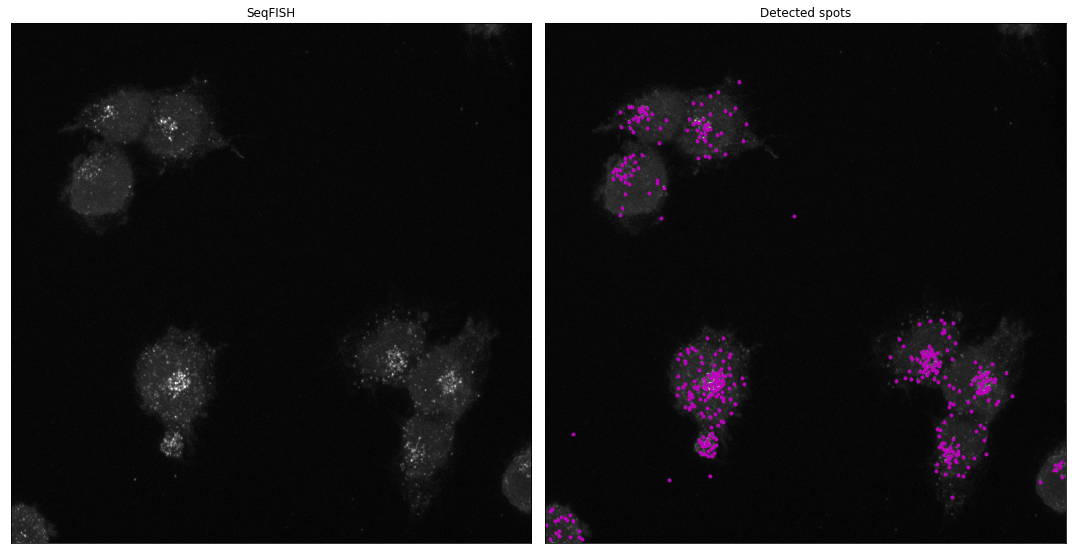

In [19]:
fig,ax = plt.subplots(1,2,figsize=(15,15))

ax[0].imshow(spots_image[0,...,0],cmap='gray',vmax=100)
ax[0].set_title('SeqFISH')
ax[1].imshow(spots_image[0,...,0],cmap='gray',vmax=100)
ax[1].scatter(df_spots.y, df_spots.x,c='m', s=8)
ax[1].set_title('Detected spots')

for i in range(np.shape(ax)[0]):
        ax[i].set_xticks([])
        ax[i].set_yticks([])

plt.tight_layout()
plt.show()